In [1]:
import pickle
import json
import numpy as np
import os

In [5]:
with open('/home/parinayok/nutr1m/data_crawl/food.com_annotated_nutr_per_recipe_old.json') as f:
    nutr_per_recipes = json.load(f)
with open('/srv/datasets2/recipe1m+/food.com_data_rescaled/nutr/simplified_food_ids_per_recipes.json') as f:
    food_ids_per_recipes = json.load(f)
with open('/srv/datasets2/recipe1m+/food.com_data_rescaled/nutr/simplified_weighted_food_ids_per_recipes.json') as f:
    weighted_food_ids_per_recipes = json.load(f)
with open('extreme_recipes.json') as f:
    extreme_recipes = json.load(f)

In [3]:
def cal_iou(input_1, input_2):
    input_1 = set(input_1)
    input_2 = set(input_2)
    u = input_1.union(input_2)
    i = input_1.intersection(input_2)
    return len(i) / len(u)
def cal_weighted_iou(input_1, input_2, w_1, w_2):
    all_weight = sum(w_1) + sum(w_2)
    intersect_weight = 0.
    for i, ingr in enumerate(input_1):
        if ingr in input_2:
            j = input_2.index(ingr)
            intersect_weight += w_1[i] + w_2[j]
    return intersect_weight / all_weight

In [6]:
# top k

def pred_nutr(top_k: int):

    gts = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    preds = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    absolute_errors = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    percentage_errors = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }

    for recipe_id, results in im2recipe_dict.items():
        top_k_results = results[:top_k]
        gt_nutr = nutr_per_recipes[recipe_id]
        pred_nutr = {}
        for nutr_name in gts.keys():
            pred_nutr[nutr_name] = sum([nutr_per_recipes[result][nutr_name] for result in top_k_results]) / top_k
        for nutr_name in gts.keys():
            gts[nutr_name].append(gt_nutr[nutr_name])
            preds[nutr_name].append(pred_nutr[nutr_name])
            absolute_errors[nutr_name].append(abs(pred_nutr[nutr_name] - gt_nutr[nutr_name]))
            if gt_nutr[nutr_name] < 0.1:
                percentage_errors[nutr_name].append(0)
            else:
                percentage_errors[nutr_name].append(abs(pred_nutr[nutr_name] - gt_nutr[nutr_name])/gt_nutr[nutr_name])
    return gts, preds, absolute_errors, percentage_errors

In [58]:
dir = 'deep_nutr_vlp/base/food_test_img_only'
im2recipe = np.load(f'../out/models/{dir}/im2recipe.npy')
recipe2im = np.load(f'../out/models/{dir}/recipe2im.npy')
with open(f'../out/models/{dir}/img_path','rb') as f:
    img_path = pickle.load(f)
with open(f'../out/models/{dir}/saved_ids','rb') as f:
    saved_ids = pickle.load(f)

In [59]:
im2recipe_dict = {}
for i, sorted_recipe in enumerate(im2recipe):
    if saved_ids[i] in extreme_recipes:
        continue
    avail_sorted_recipe = []
    for idx in sorted_recipe:
        if idx == i or saved_ids[idx] in extreme_recipes:
            continue
        avail_sorted_recipe.append(saved_ids[idx])
        if len(avail_sorted_recipe) == 20:
            break
    im2recipe_dict[saved_ids[i]] = avail_sorted_recipe
save_path = f'results_wo_extreme/{dir}.json'
os.makedirs(os.path.dirname(save_path),exist_ok=True)
with open(f'results_wo_extreme/{dir}.json','w') as f:
    json.dump(im2recipe_dict,f,indent=2)

In [60]:
ious = []
weighted_ious = []
for recipe_id, results in im2recipe_dict.items():
    result = results[0]
    ious.append(cal_iou(food_ids_per_recipes[recipe_id],food_ids_per_recipes[result]))
    weighted_ious.append(cal_weighted_iou(food_ids_per_recipes[recipe_id],food_ids_per_recipes[result],weighted_food_ids_per_recipes[recipe_id]['weight'],weighted_food_ids_per_recipes[result]['weight']))
iou = sum(ious)/len(ious)
print(f'{iou*100:.02f}%')
weighted_iou = sum(weighted_ious)/len(weighted_ious)
print(f'{weighted_iou*100:.02f}%')

24.15%
45.02%


In [61]:
#top1
gts, preds, absolute_errors, percentage_errors = pred_nutr(1)
all_mape = []
for nutr_name in gts.keys():
    mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
    mape = sum(percentage_errors[nutr_name])/len(percentage_errors[nutr_name])
    m = np.array(gts[nutr_name]).mean()
    se = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
    print(f'{nutr_name}: MAE = {mae:.02f}, MAPE = {mape:.02f}, SE = {se:.02f}')
    all_mape.append(mape)
print(f'{sum(all_mape)/4:.02f}')
#toop5
gts, preds, absolute_errors, percentage_errors = pred_nutr(5)
all_mape = []
for nutr_name in gts.keys():
    mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
    mape = sum(percentage_errors[nutr_name])/len(percentage_errors[nutr_name])
    m = np.array(gts[nutr_name]).mean()
    se = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
    print(f'{nutr_name}: MAE = {mae:.02f}, MAPE = {mape:.02f}, SE = {se:.02f}')
    all_mape.append(mape)
print(f'{sum(all_mape)/4:.02f}')
#top10
gts, preds, absolute_errors, percentage_errors = pred_nutr(10)
all_mape = []
for nutr_name in gts.keys():
    mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
    mape = sum(percentage_errors[nutr_name])/len(percentage_errors[nutr_name])
    m = np.array(gts[nutr_name]).mean()
    se = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
    print(f'{nutr_name}: MAE = {mae:.02f}, MAPE = {mape:.02f}, SE = {se:.02f}')
    all_mape.append(mape)
print(f'{sum(all_mape)/4:.02f}')

energy: MAE = 1168.80, MAPE = 1.09, SE = 1247.00
fat: MAE = 72.16, MAPE = 4.23, SE = 72.06
carb: MAE = 143.41, MAPE = 2.34, SE = 180.57
protein: MAE = 44.39, MAPE = 2.19, SE = 50.85
2.46
energy: MAE = 929.75, MAPE = 1.10, SE = 1247.00
fat: MAE = 57.62, MAPE = 4.29, SE = 72.06
carb: MAE = 116.49, MAPE = 2.14, SE = 180.57
protein: MAE = 35.94, MAPE = 2.32, SE = 50.85
2.47
energy: MAE = 897.33, MAPE = 1.09, SE = 1247.00
fat: MAE = 55.32, MAPE = 4.47, SE = 72.06
carb: MAE = 112.41, MAPE = 2.18, SE = 180.57
protein: MAE = 34.68, MAPE = 2.27, SE = 50.85
2.50


0.3989
0.3470
0.4828
0.4089


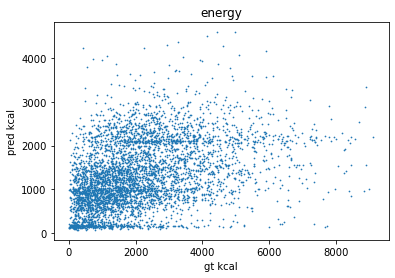

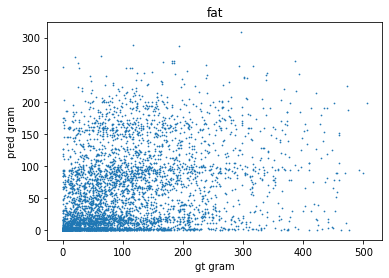

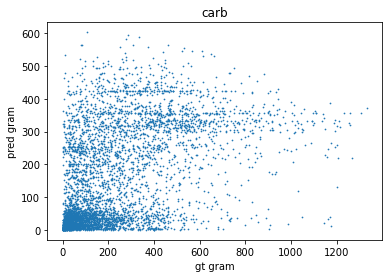

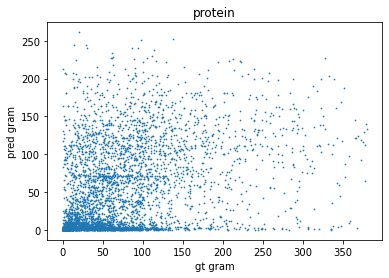

In [24]:
import matplotlib.pyplot as plt

for nutr_name in gts.keys():
    cc = np.corrcoef(gts[nutr_name],preds[nutr_name])[0,1]
    print(f'{cc:.04f}')
    plt.figure()
    plt.scatter(gts[nutr_name],preds[nutr_name],s=0.5)
    if nutr_name == 'energy':
        plt.xlabel('gt kcal')
        plt.ylabel('pred kcal')
        # plt.xlim((0,2500))
        # plt.ylim((0,2500))
    else:
        plt.xlabel('gt gram')
        plt.ylabel('pred gram')
        # plt.xlim((0,200))
        # plt.ylim((0,200))
    plt.title(nutr_name)

In [47]:
# top 5

import numpy as np
gts, preds, absolute_errors, percentage_errors = pred_nutr(5)
all_mape = []
for nutr_name in gts.keys():
    mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
    mape = sum(percentage_errors[nutr_name])/len(percentage_errors[nutr_name])
    m = np.array(gts[nutr_name]).mean()
    se = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
    print(f'{nutr_name}: MAE = {mae:.02f}, MAPE = {mape:.02f}, SE = {se:.02f}')
    all_mape.append(mape)
print(f'{sum(all_mape)/4:.02f}')

energy: MAE = 1074.51, MAPE = 1.04, SE = 1395.87
fat: MAE = 66.49, MAPE = 4.94, SE = 81.85
carb: MAE = 124.86, MAPE = 2.63, SE = 191.63
protein: MAE = 43.10, MAPE = 2.23, SE = 58.82
2.71


0.5695
0.4768
0.6618
0.5424


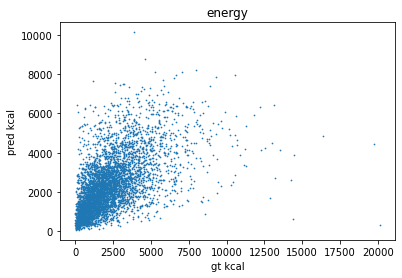

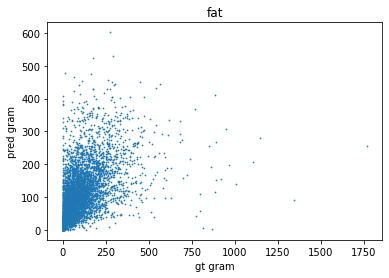

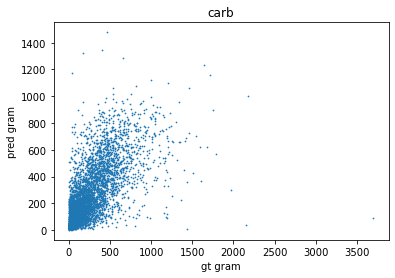

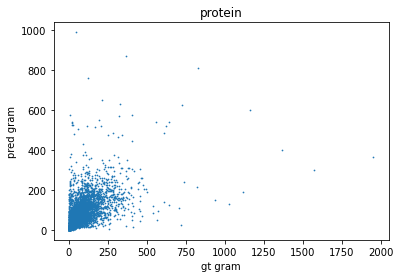

In [48]:
import matplotlib.pyplot as plt

for nutr_name in gts.keys():
    cc = np.corrcoef(gts[nutr_name],preds[nutr_name])[0,1]
    print(f'{cc:.04f}')
    plt.figure()
    plt.scatter(gts[nutr_name],preds[nutr_name],s=0.5)
    if nutr_name == 'energy':
        plt.xlabel('gt kcal')
        plt.ylabel('pred kcal')
    else:
        plt.xlabel('gt gram')
        plt.ylabel('pred gram')
    plt.title(nutr_name)

In [49]:
# top 10

import numpy as np
gts, preds, absolute_errors, percentage_errors = pred_nutr(10)
all_mape = []
for nutr_name in gts.keys():
    mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
    mape = sum(percentage_errors[nutr_name])/len(percentage_errors[nutr_name])
    m = np.array(gts[nutr_name]).mean()
    se = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
    print(f'{nutr_name}: MAE = {mae:.02f}, MAPE = {mape:.02f}, SE = {se:.02f}')
    all_mape.append(mape)
print(f'{sum(all_mape)/4:.02f}')

energy: MAE = 1038.61, MAPE = 1.06, SE = 1395.87
fat: MAE = 64.22, MAPE = 5.12, SE = 81.85
carb: MAE = 122.41, MAPE = 2.57, SE = 191.63
protein: MAE = 41.79, MAPE = 2.19, SE = 58.82
2.73


0.5261
0.4312
0.6228
0.4862


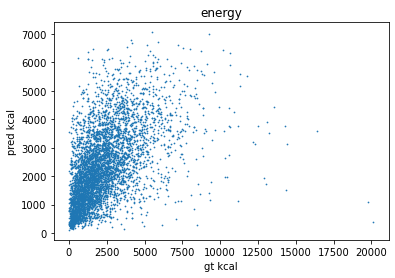

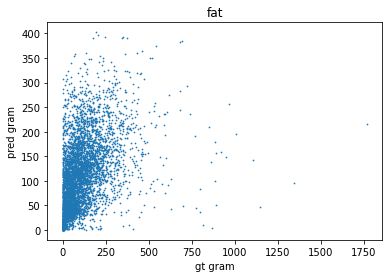

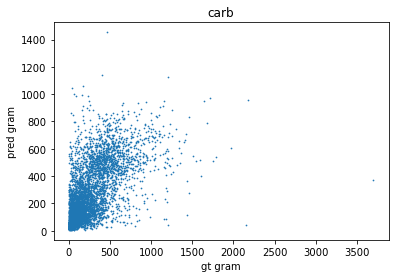

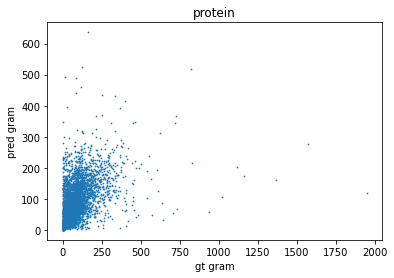

In [91]:
import matplotlib.pyplot as plt

for nutr_name in gts.keys():
    cc = np.corrcoef(gts[nutr_name],preds[nutr_name])[0,1]
    print(f'{cc:.04f}')
    plt.figure()
    plt.scatter(gts[nutr_name],preds[nutr_name],s=0.5)
    if nutr_name == 'energy':
        plt.xlabel('gt kcal')
        plt.ylabel('pred kcal')
    else:
        plt.xlabel('gt gram')
        plt.ylabel('pred gram')
    plt.title(nutr_name)

In [ ]:
# random_ious = []
# random_weighted_ious = []
# for recipe_id in im2recipe_dict.keys():
#     for recipe_target in im2recipe_dict.keys():
#         if recipe_id == recipe_target:
#             continue
#         random_ious.append(cal_iou(food_ids_per_recipes[recipe_id],food_ids_per_recipes[recipe_target]))
#         random_weighted_ious.append(cal_weighted_iou(food_ids_per_recipes[recipe_id],food_ids_per_recipes[recipe_target],weighted_food_ids_per_recipes[recipe_id]['weight'],weighted_food_ids_per_recipes[recipe_target]['weight']))

In [ ]:
# random_iou = sum(random_ious) / len(random_ious)
# print(f'{random_iou:.02f}')
# random_weighted_iou = sum(random_weighted_ious) / len(random_weighted_ious)
# print(f'{random_weighted_iou:.02f}')